In [1]:
from scipy.io import loadmat, savemat
from scipy.linalg import orth
import numpy as np
import faiss
from scipy.spatial.distance import cdist
import pandas as pd

from tqdm import tqdm
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import gc
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..', 'lib')))

from randn2 import randn2 
import peer_functions as peer

import math
from tqdm import tqdm
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [2]:
def calculate_evaluation_metrics(similarity_matrix, ground_truth):
    """
    Calculate evaluation metrics for place recognition results
    
    Args:
        similarity_matrix: Matrix of similarity scores between queries and database
        ground_truth: Ground truth data containing GThard and GTsoft
        
    Returns:
        dict: Dictionary containing recalls, precision, recall curves and AUC
    """
    # Get candidate selections
    ids_pos = peer.directCandSel(similarity_matrix)
    
    # Calculate recall values
    recalls = peer.getRecallAtKVector(ids_pos, ground_truth["GT"])
    
    # Calculate precision-recall curves and AUC
    [R, P] = peer.createPR(-similarity_matrix, 
                          ground_truth['GT']["GThard"][0][0], 
                          ground_truth['GT']["GTsoft"][0][0])
    auc = np.trapz(P, R)
    
    return {
        'recalls': recalls,
        'precision': P,
        'recall': R,
        'auc': auc
    }



In [3]:
# D1    = loadmat("../datasets/descriptors/GardensPointWalking/day_left/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']
# D2    = loadmat("../datasets/descriptors/GardensPointWalking/night_right/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']

D1    = loadmat("../datasets/descriptors/SFUMountain/dry/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']
D2    = loadmat("../datasets/descriptors/SFUMountain/dusk/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']

g_truth = loadmat("../datasets/ground_truth/SFUMountain/dry--dusk/gt.mat")


In [4]:
normalizer = Normalizer()

mu1 = np.mean(D1,axis=0)

dbVectors_centered = np.subtract(D1,mu1)

dbVectors_norm = normalizer.fit_transform(dbVectors_centered)

In [5]:
from dot_product import  LoihiDotProductSimulationPositive


c:\Users\21361535\AppData\Local\anaconda3\envs\lava3\lib\site-packages\lava\utils\profiler.py:16: UserWarning: Loihi2HWProfiler could not be imported. Currently no profiler is available.
  warnings.warn("Loihi2HWProfiler could not be imported. "


In [6]:
constant = 1/math.sqrt(2)

dot = LoihiDotProductSimulationPositive(D1, D2, constant)


In [7]:
DD, qs, dbs = dot.run()

queryVector :
[[ 35.18420792  13.55408192  25.27115631 ... -21.1640377   29.03779221  10.87193871]
 [ 24.57668304  13.1932888   25.17643356 ... -25.78697968  28.48844528  16.98944473]
 [ -6.30864334 -17.13254166  20.65517807 ... -20.74441147  17.4224968   11.46131134]
 ...
 [ -9.30115128  17.11267662 -30.61633492 ... -18.35195923  28.02412796  11.13977337]
 [ 31.4378891   -6.16335201  17.2170372  ... -30.81082726  18.54884148  34.05539703]
 [ 10.66497231  16.95552826  -5.16359711 ... -22.75413132  -3.41729784  21.66749763]]
mean_center_norm_positive :
[[0.7374193  0.7093695  0.72804809 ... 0.70891478 0.7186306  0.7087943 ]
 [0.72983429 0.70914382 0.72852259 ... 0.70530998 0.7184989  0.71367153]
 [0.70554736 0.68666882 0.72374347 ... 0.70914576 0.70957729 0.70915552]
 ...
 [0.703617   0.71154469 0.68751555 ... 0.71063141 0.71663824 0.70878685]
 [0.72974218 0.69644759 0.71927182 ... 0.70247022 0.70995318 0.72322788]
 [0.7162651  0.71101552 0.70511431 ... 0.70757435 0.69632765 0.71511304]

100%|██████████| 385/385 [03:41<00:00,  1.74it/s]


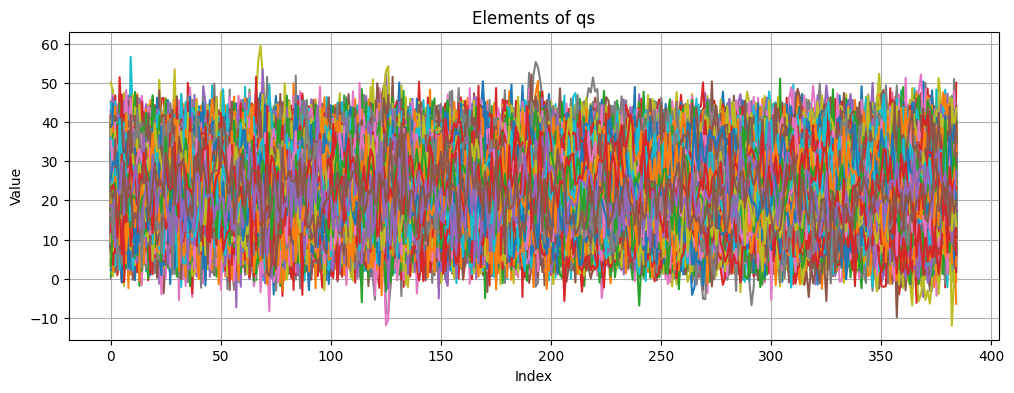

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(qs)
# plt.plot(qs[1], '-')
# plt.plot(qs[2], '-')
plt.title('Elements of qs')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

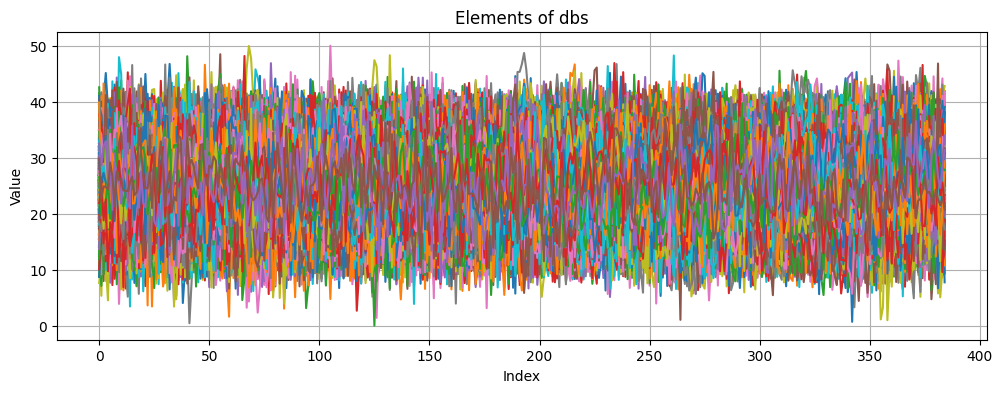

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(dbs)
# plt.plot(qs[1], '-')
# plt.plot(qs[2], '-')
plt.title('Elements of dbs')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [10]:
# Compute dot product between all pairs of vectors
dot_product_matrix = np.dot(qs, dbs.T)  # This will give a 200x200 matrix

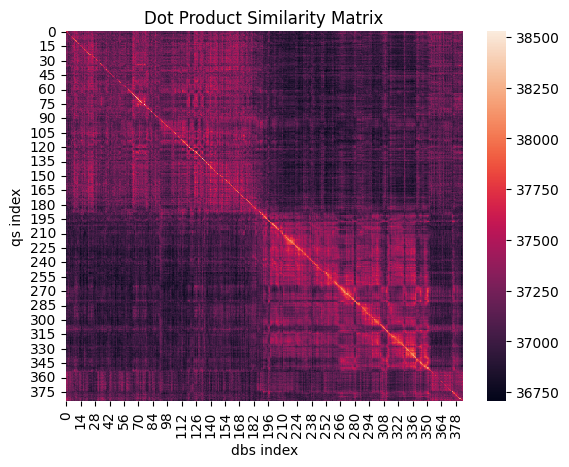

In [11]:
import seaborn as sns

ax = sns.heatmap(dot_product_matrix/2**6)
plt.title('Dot Product Similarity Matrix')
plt.xlabel('dbs index')
plt.ylabel('qs index')
plt.show()

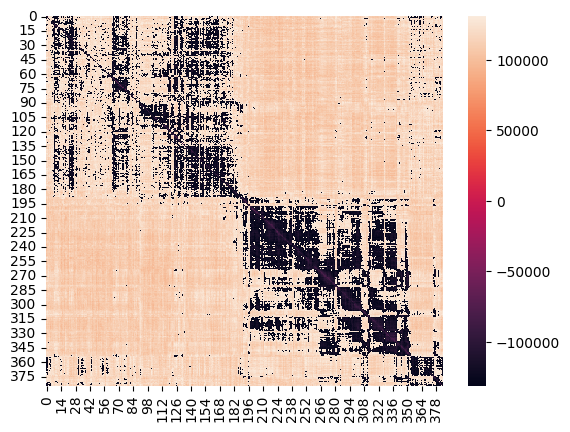

In [12]:
import seaborn as sns

ax = sns.heatmap(DD)
plt.show()

In [15]:

metrics = calculate_evaluation_metrics(DD, g_truth)
print(f"AUC: {metrics['auc']}")

# You can also access other metrics if needed:
# print(f"Recalls: {metrics['recalls']}")
# print(f"Precision: {metrics['precision']}")
# print(f"Recall: {metrics['recall']}")

AUC: 0.008615433233782


In [14]:
0.406751268123599
0.406751268123599
0.406751268123599
0.41105831265952125 # Dense layer multiplied by 10 not timesteps (signs of overflow) -2,000
0.022280486025402297 # Dense layer multiplier changed to 1
0.4147533173640495 # Dense layer multiplied by 20 (signs of overflow) -10,000
# ============================================ Upto this, the constant is 0
0.005699984139190401 # Constant changed to 1/sqrt(2)
0.29100275201856207 # Constant changed to 0 while the vector transformation is done as per positive cpu experiment
0.4528012779410795
0.45785226214439223
0.4634606913087941

0.4634606913087941